In [ ]:
# Importação de bibliotecas e configuração de caminhos
from google.colab import drive
drive.mount('/content/drive')

import os
import re
from time import sleep
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parâmetro para sleep entre requests
REQUEST_SLEEP = 0.95

# Caminhos dos dados
SPECTRA_PATH = '../datasets/spectras/'
DATASET_PATH = '../datasets'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Função para ler arquivos JCAMP (.jdx) com encoding latin-1
def JCAMP_reader(cas_number, spectra_path=SPECTRA_PATH):
    """
    Lê arquivos JCAMP (.jdx) usando encoding latin-1.
    Args:
        cas_number (str): Número CAS do composto.
        spectra_path (str): Caminho para os espectros.
    Returns:
        dict: Dados extraídos do arquivo JCAMP.
    """
    filename = os.path.join(spectra_path, f'{cas_number}-IR.jdx')
    from jcamp import jcamp_read
    with open(filename, 'r', encoding='latin-1') as filehandle:
        data = jcamp_read(filehandle)
    data['filename'] = filename
    return data

# Dicionário de grupos funcionais e seus SMARTS
func_grp_smarts = {
    'alkane':'[CX4;H0,H1,H2,H4]',
    'methyl':'[CH3]',
    'alkene':'[CX3]=[CX3]',
    'alkyne':'[CX2]#C',
    'alcohols':'[#6][OX2H]',
    'amines':'[NX3;H2,H1;!$(NC=O)]',
    'nitriles':'[NX1]#[CX2]',
    'aromatics':'[$([cX3](:*):*),$([cX2+](:*):*)]',
    'alkyl halides':'[#6][F,Cl,Br,I]',
    'esters':'[#6][CX3](=O)[OX2H0][#6]',
    'ketones':'[#6][CX3](=O)[#6]',
    'aldehydes':'[CX3H1](=O)[#6]',
    'carboxylic acids':'[CX3](=O)[OX2H1]',
    'ether': '[OD2]([#6])[#6]',
    'acyl halides':'[CX3](=[OX1])[F,Cl,Br,I]',
    'amides':'[NX3][CX3](=[OX1])[#6]',
    'nitro':'[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]'
  }

column_names = list(func_grp_smarts.keys())

# Função para processar espectros
def process_spectra(cas_number, bins, agg_str, normalization=True):
    mol_dict = JCAMP_reader(cas_number)
    mol_id = mol_dict['cas registry no']
    mol_xvalues = mol_dict['x']
    if mol_dict['yunits'] == 'TRANSMITTANCE':
        mol_yvalues = 2 - np.log10(mol_dict['y']*100)
    else:
        mol_yvalues = mol_dict['y']
    if normalization:
        mol_yvalues = mol_yvalues / np.max(mol_yvalues)
    mol_df = pd.DataFrame({mol_id: mol_yvalues}, index=mol_xvalues)
    mol_df.index = pd.cut(mol_df.index, bins=bins)
    mol_df_agg = mol_df.groupby(level=0, observed=True).agg(agg_str)
    return mol_df_agg

# Função para unir espectros em um DataFrame
def glue_spectra(df_enrich, agg_str, bins, save=False, interpolate=True):
    ir_df = pd.DataFrame({'bins': bins}, index=bins)
    ir_df.index = pd.cut(ir_df.index, bins=bins)
    df_spectra_all = ir_df.copy()
    size = len(df_enrich.CAS.values)
    for i, cas in enumerate(df_enrich.CAS.values):
        print(f'Processando CAS {cas}: {i} ({i/size*100:.2f}%)')
        df_spectra = process_spectra(cas, bins, agg_str)
        df_spectra_all = pd.merge(df_spectra_all, df_spectra, left_index=True, right_index=True, how='left')
    df_spectra_all.columns = [x+f'_{agg_str}' for x in df_spectra_all.columns]
    if save:
        df_spectra_all.to_csv(f'{DATASET_PATH}/df_spectra_all_{agg_str}_nointerpolate.csv', index=False)
    df_spectra_all.reset_index(inplace=True)
    if interpolate:
        df_spectra_all.iloc[:, 1:] = df_spectra_all.iloc[:, 1:].interpolate(method='linear', limit_direction='both', axis=0)
        if save:
            df_spectra_all.to_csv(f'{DATASET_PATH}/df_spectra_all_{agg_str}_interpolate.csv', index=False)
    return df_spectra_all

In [ ]:
min_ir = 399
max_ir = 4001
step_ir = 3.5
eps = 1e-4
ir_bins = np.arange(min_ir - eps, max_ir + eps, step_ir)

df_enrich = pd.read_csv(f'{DATASET_PATH}/df_enrich_all.csv')

In [30]:
ir_bins

array([ 398.9999,  402.4999,  405.9999, ..., 3993.4999, 3996.9999,
       4000.4999])

In [31]:
df_enrich['x_rule'] = df_enrich['xunits'].apply(lambda x: 1 if 'cm' in str(x).lower() else 0)
df_enrich['y_rule'] = df_enrich['yunits'].apply(lambda x: 1 if str(x).upper() in ['ABSORBANCE'] else 0)
df_enrich['state_rule'] = df_enrich['state'].apply(lambda x:  1 if 'gas' in str(x).lower() else 0)

df_enrich['all_rules'] = df_enrich['x_rule'] + df_enrich['y_rule'] + df_enrich['state_rule']
df_enrich = df_enrich[df_enrich['all_rules'] == 3]
df_enrich.reset_index(inplace = True, drop = True)

In [32]:
df_enrich['yunits'].value_counts()

,count
yunits,
ABSORBANCE,8210


In [33]:
# df_spectra_all_min = glue_spectra(df_enrich, agg_str = 'min', bins = ir_bins, save = True, interpolate = True)
# print(df_spectra_all_min.shape)
# df_spectra_all_max = glue_spectra(df_enrich, agg_str = 'max', bins = ir_bins, save = True, interpolate = True)
# print(df_spectra_all_max.shape)
# df_spectra_all_mean = glue_spectra(df_enrich, agg_str = 'mean', bins = ir_bins, save = True, interpolate = True)
# print(df_spectra_all_mean.shape)


In [ ]:
# df_spectra_all = pd.merge(df_spectra_all_mean, pd.merge(df_spectra_all_min, df_spectra_all_max, left_index = True, right_index = True, how='left'), left_index = True, right_index = True, how='left')
# df_spectra_all.to_csv(f'{DATASET_PATH}//df_spectra_all_mixture_interpolate.csv',index=False)
df_spectra_all = pd.read_csv(f'{DATASET_PATH}//df_spectra_all_mixture_interpolate.csv')
df_spectra_all

,index,bins_mean,71-55-6_x_mean,84-66-2_mean,99-94-5_mean,99-04-7_mean,71-55-6_y_mean,112-54-9_mean,79-00-5_mean,79-01-6_mean,...,626-01-7_max,632-21-3_max,2044-21-5_max,4122-52-5_max,41197-29-9_max,15872-41-0_max,354-76-7_max,2702-58-1_max,622-25-3_max,366-18-7_max
0,NaN,398.9999,0.0076,0.0054,0.0803,0.0043,0.0076,0.0050,0.0000,0.1297,...,0.0937,0.061,0.0035,0.012347,0.325401,0.048674,0.032021,0.002838,0.046224,0.0179
1,"(399.0, 402.5]",402.4999,0.0076,0.0054,0.0803,0.0043,0.0076,0.0050,0.0000,0.1297,...,0.0937,0.061,0.0035,0.012347,0.325401,0.048674,0.032021,0.002838,0.046224,0.0179
2,"(402.5, 406.0]",405.9999,0.0076,0.0054,0.0803,0.0043,0.0076,0.0050,0.0000,0.1297,...,0.0937,0.061,0.0035,0.012347,0.325401,0.048674,0.032021,0.002838,0.046224,0.0179
3,"(406.0, 409.5]",409.4999,0.0076,0.0054,0.0803,0.0043,0.0076,0.0050,0.0000,0.1297,...,0.0937,0.061,0.0035,0.012347,0.325401,0.048674,0.032021,0.002838,0.046224,0.0179
4,"(409.5, 413.0]",412.9999,0.0076,0.0054,0.0803,0.0043,0.0076,0.0050,0.0000,0.1297,...,0.0937,0.061,0.0035,0.012347,0.325401,0.048674,0.032021,0.002838,0.046224,0.0179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,"(3983.0, 3986.5]",3986.4999,0.0081,0.0016,0.0048,0.0045,0.0081,0.0043,0.0061,0.0011,...,0.0000,0.005,0.0025,0.003103,0.016146,0.002083,0.001447,0.002707,0.011573,0.0035
1026,"(3986.5, 3990.0]",3989.9999,0.0081,0.0016,0.0048,0.0045,0.0081,0.0043,0.0061,0.0011,...,0.0000,0.005,0.0025,0.003035,0.019972,0.002372,0.001214,0.003402,0.011434,0.0035
1027,"(3990.0, 3993.5]",3993.4999,0.0081,0.0016,0.0048,0.0045,0.0081,0.0043,0.0061,0.0011,...,0.0000,0.005,0.0025,0.003677,0.020367,0.002362,0.001018,0.003727,0.012546,0.0035
1028,"(3993.5, 3997.0]",3996.9999,0.0081,0.0016,0.0048,0.0045,0.0081,0.0043,0.0061,0.0011,...,0.0000,0.005,0.0025,0.003975,0.017597,0.001788,0.002215,0.003819,0.014006,0.0035


In [35]:
df_enrich['npoints'].min()

825.0

In [36]:
divergence_list = []
diff_list = []
for cas in df_enrich.CAS.to_list(): #['6921-98-8']:

  cols = [f'{cas}_max',f'{cas}_mean',f'{cas}_min']
  try:
    df_spectra_cas = df_spectra_all[cols]
  except KeyError:
    continue

  flag_1 = abs(df_spectra_cas[cols[0]] - df_spectra_cas[cols[1]])
  flag_2 = abs(df_spectra_cas[cols[1]] - df_spectra_cas[cols[2]])
  flag_3 = abs(df_spectra_cas[cols[0]] - df_spectra_cas[cols[2]])
  final_test = flag_1.sum() + flag_2.sum() + flag_3.sum()

  if final_test > 0:
    divergence_list.append(cas)

    diff_list.append(abs(df_spectra_cas.diff(axis=1).max(axis=1).values))
    # print(cas)


  # display(df_spectra_cas)

len(divergence_list)

2944

In [37]:
df_enrich.shape

(8210, 41)

In [38]:
diff_df = pd.DataFrame(diff_list)
primary_cols = diff_df.columns

temp = diff_df.copy()
temp['max_diff'] = diff_df[primary_cols].max(axis=1)
temp['mean_diff'] = temp[primary_cols].mean(axis=1)
temp['min_diff'] = temp[primary_cols].min(axis=1)
temp['std_diff'] = temp[primary_cols].std(axis=1)
temp['CAS'] = divergence_list

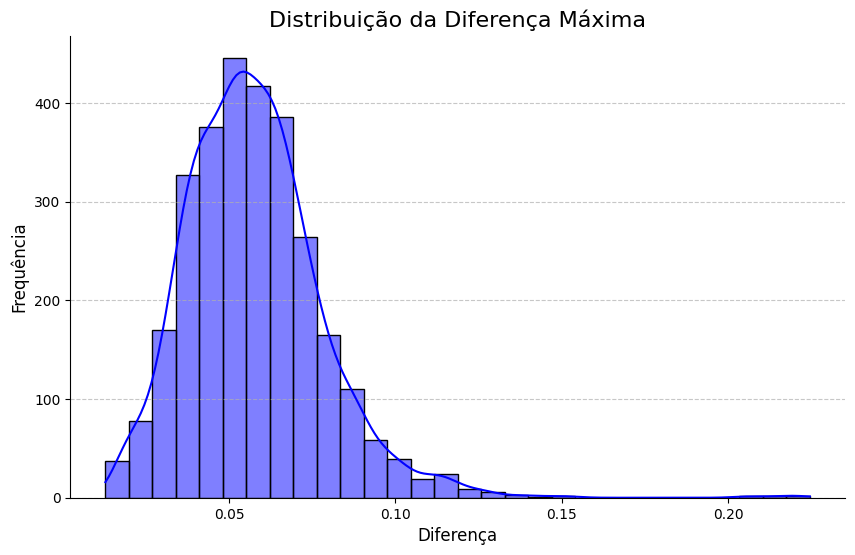

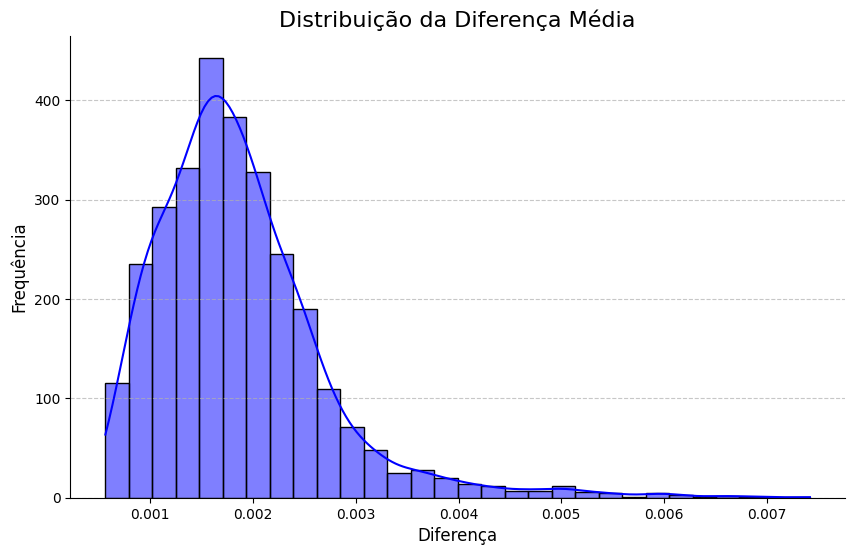

In [ ]:
## Análise diferença entre agregações

import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(data, x_col, title, x_label, y_label):
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.histplot(data[x_col], kde=True, bins=30, color='blue', edgecolor='black')  # Use histplot for distributions
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sns.despine() #remove top and right spines
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Customize gridlines
    plt.show()


# Example usage (replace with your actual data and column names):
plot_distribution(temp, 'max_diff', 'Distribuição da Diferença Máxima', 'Diferença', 'Frequência')
plot_distribution(temp, 'mean_diff', 'Distribuição da Diferença Média', 'Diferença', 'Frequência')


In [40]:
# prompt: I want to generate the intercal confidence of the metric max_diff

import numpy as np
import scipy.stats as st

def intercal_confidence(data, confidence=0.95):
    """
    Calculate the confidence interval for the given data.

    Args:
        data (array-like): The data for which to calculate the confidence interval.
        confidence (float, optional): The confidence level. Defaults to 0.95.

    Returns:
        tuple: A tuple containing the lower and upper bounds of the confidence interval.
    """
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

# Example usage:
lower_bound, upper_bound = intercal_confidence(temp['max_diff'])
print(f"The {0.95*100:.0f}% confidence interval for max_diff is: ({lower_bound:.4f}, {upper_bound:.4f})")


lower_bound, upper_bound = intercal_confidence(temp['mean_diff'])
print(f"The {0.95*100:.0f}% confidence interval for mean_diff is: ({lower_bound:.4f}, {upper_bound:.4f})")


The 95% confidence interval for max_diff is: (0.0569, 0.0584)
The 95% confidence interval for mean_diff is: (0.0018, 0.0019)


In [41]:
from scipy.stats import shapiro

def check_normality(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

check_normality(temp['max_diff'])
check_normality(temp['mean_diff'])


Statistics=0.931, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.882, p=0.000
Sample does not look Gaussian (reject H0)


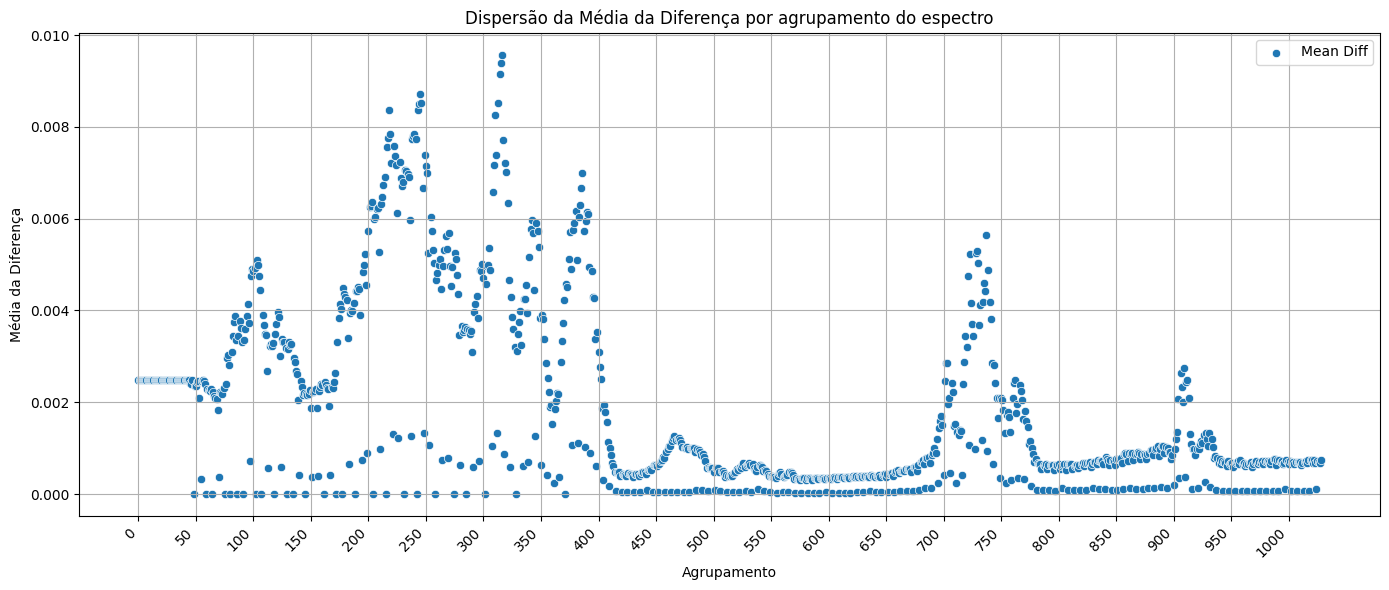

In [42]:
# prompt: I want to generate a image showing the mean value of the diff_df cell for each column. The X axis will be Column number and Y will be the mean.

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean of each column in diff_df
mean_values = diff_df.iloc[:, :-1].mean()
std_values = diff_df.iloc[:, :-1].std()
ic_lower = mean_values - 1.96 * std_values/np.sqrt(len(diff_df))
ic_upper = mean_values + 1.96 * std_values/np.sqrt(len(diff_df))


# Create the plot
plt.figure(figsize=(14, 6))
sns.scatterplot(x = mean_values.index, y = mean_values.values, label = 'Mean Diff')
# sns.scatterplot(x = mean_values.index, y = ic_lower.values, color = 'red', label = 'IC Lower')
# sns.scatterplot(x = mean_values.index, y = ic_upper.values, color = 'green', label = 'IC Upper')
plt.xlabel('Agrupamento')
plt.ylabel('Média da Diferença')
plt.title('Dispersão da Média da Diferença por agrupamento do espectro')
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xticks(np.arange(0, 1031, 50)) # Adjust the step (0.1) as needed
plt.tight_layout()
plt.show()


In [43]:

df_enrich[df_enrich.CAS.isin(temp['CAS'].unique())][column_names].sum(axis=1).value_counts().sort_index()

df_enrich['has_change'] = df_enrich['CAS'].apply(lambda x: 1 if x in divergence_list else 0)
(df_enrich[column_names].sum(axis=0)/df_enrich.shape[0]*100).sort_values(ascending=False)

,0
alkane,68.915956
methyl,64.116931
aromatics,57.734470
alkyl halides,27.673569
alcohols,27.003654
ether,24.847747
alkene,13.410475
esters,11.096224
amines,9.427527
ketones,9.123021


In [44]:
df_changed = df_enrich[df_enrich['has_change'] == 1].copy()
(df_changed[column_names].sum(axis=0)/df_changed.shape[0]*100).sort_values(ascending=False)

,0
aromatics,76.528533
alkane,61.752717
methyl,56.963315
alkyl halides,36.786685
ether,29.415761
alcohols,28.023098
carboxylic acids,11.141304
amines,10.733696
esters,10.394022
ketones,9.884511


In [45]:
# prompt: I want to conduct a Qui-square test between the columns names and has_change column. The function needs to give me the Null hypotesis and if we reject or not

import pandas as pd
import scipy.stats as stats

def chi_square_test(df, columns, target_column):
    """
    Performs a chi-square test of independence between multiple columns and a target column.

    Args:
        df: The pandas DataFrame containing the data.
        columns: A list of column names to test against the target column.
        target_column: The name of the target column.

    Returns:
        A dictionary containing the results of the chi-square test for each column:
        - column_name: The name of the column being tested.
        - chi2: The chi-square statistic.
        - p_value: The p-value of the test.
        - dof: The degrees of freedom.
        - null_hypothesis: Statement of the null hypothesis.
        - reject_null: Boolean indicating whether to reject the null hypothesis (True if p-value < 0.05).

    """

    results = []
    for col in columns:
        contingency_table = pd.crosstab(df[col], df[target_column])
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        null_hypothesis = f"There is no association between '{col}' and '{target_column}'."
        reject_null = p < 0.05

        results.append({
            'column_name': col,
            'chi2': chi2,
            'p_value': p,
            'dof': dof,
            'null_hypothesis': null_hypothesis,
            'reject_null': reject_null
        })

    return results


# Example usage:
results = chi_square_test(df_enrich, column_names, 'has_change')
for result in results:
    print(f"Column: {result['column_name']}")
    print(f"  Null Hypothesis: {result['null_hypothesis']}")
    print(f"  Chi2: {result['chi2']:.3f}")
    print(f"  P-value: {result['p_value']:.3f}")
    print(f"  Degrees of freedom: {result['dof']}")
    print(f"  Reject Null Hypothesis: {result['reject_null']}")
    print("-" * 20)


Column: alkane
  Null Hypothesis: There is no association between 'alkane' and 'has_change'.
  Chi2: 109.421
  P-value: 0.000
  Degrees of freedom: 1
  Reject Null Hypothesis: True
--------------------
Column: methyl
  Null Hypothesis: There is no association between 'methyl' and 'has_change'.
  Chi2: 101.607
  P-value: 0.000
  Degrees of freedom: 1
  Reject Null Hypothesis: True
--------------------
Column: alkene
  Null Hypothesis: There is no association between 'alkene' and 'has_change'.
  Chi2: 87.234
  P-value: 0.000
  Degrees of freedom: 1
  Reject Null Hypothesis: True
--------------------
Column: alkyne
  Null Hypothesis: There is no association between 'alkyne' and 'has_change'.
  Chi2: 4.229
  P-value: 0.040
  Degrees of freedom: 1
  Reject Null Hypothesis: True
--------------------
Column: alcohols
  Null Hypothesis: There is no association between 'alcohols' and 'has_change'.
  Chi2: 2.340
  P-value: 0.126
  Degrees of freedom: 1
  Reject Null Hypothesis: False
-----------